In [1]:
!pip install kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [2]:

!kaggle datasets download paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:09<00:00, 73.4MB/s]
100% 1.15G/1.15G [00:09<00:00, 127MB/s] 


In [3]:
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          
Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/

In [4]:
import time
import matplotlib.pyplot as plt
import numpy as np

import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor) 
!pip install -U syft
try:
  import syft as sy
except ModuleNotFoundError:
  !pip install syft
  import syft as sy
from syft.frameworks.torch.federated import FederatedDataset, FederatedDataLoader, BaseDataset
from torchvision import transforms
from torchvision import datasets

     |████████████████████████████████| 225kB 6.5MB/s 
     |████████████████████████████████| 256kB 40.6MB/s 
     |████████████████████████████████| 389kB 39.7MB/s 
     |████████████████████████████████| 204kB 40.4MB/s 
     |████████████████████████████████| 81kB 25.9MB/s 
     |████████████████████████████████| 450kB 35.8MB/s 
     |████████████████████████████████| 1.4MB 38.3MB/s 
     |████████████████████████████████| 51kB 20.1MB/s 
     |████████████████████████████████| 276kB 42.8MB/s 
     |████████████████████████████████| 122kB 42.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/ad/9a/f4/3105b5209674ac77fcca7fede95184c62a95df0196888e0e76
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built zstd pyyaml
  Found existing installation: msgpack 0.5.6
    Uninstalling msgpack-0.5.6:
      Successfully uninstalled msgpack-0.5.6
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
   

W0718 19:31:40.996114 140694006953856 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0718 19:31:41.019202 140694006953856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



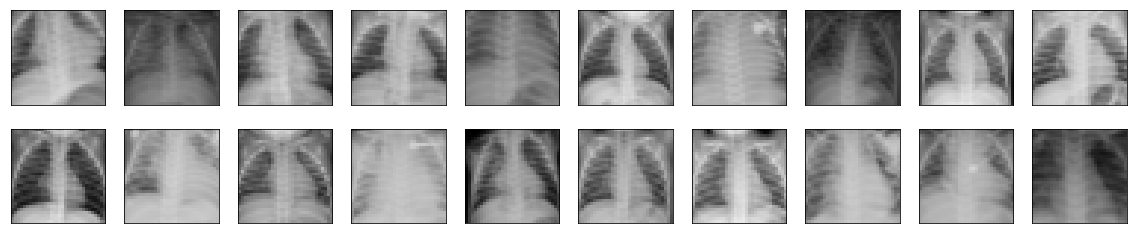

In [5]:
transforms_image = transforms.Compose([transforms.Resize(32),
                                     transforms.CenterCrop(32),
                                     transforms.ToTensor()])
train_xray = torch.utils.data.DataLoader(datasets.ImageFolder('chest_xray/train', 
                                                                            transform=transforms_image),
                                                        batch_size=20, shuffle=True)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(train_xray)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


In [6]:
# Using GPU if available else using CPU
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [7]:
hook = sy.TorchHook(torch)
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
gob = sy.VirtualWorker(hook, id="gob")
maybe = sy.VirtualWorker(hook, id="maybe")
secure_worker = sy.VirtualWorker(hook, id = "secure_worker")
bob.add_workers([alice, secure_worker,gob,maybe])
alice.add_workers([bob, secure_worker,gob,maybe])
secure_worker.add_workers([alice, bob,gob,maybe])
gob.add_workers([bob,alice,maybe,secure_worker])

maybe.add_workers([bob,alice,gob,secure_worker])

bob.clear_objects()
alice.clear_objects()
gob.clear_objects()
maybe.clear_objects()
secure_worker.clear_objects()


W0718 19:31:48.628616 140694006953856 base.py:628] Worker alice already exists. Replacing old worker which could cause                     unexpected behavior
W0718 19:31:48.630568 140694006953856 base.py:628] Worker secure_worker already exists. Replacing old worker which could cause                     unexpected behavior
W0718 19:31:48.631613 140694006953856 base.py:628] Worker gob already exists. Replacing old worker which could cause                     unexpected behavior
W0718 19:31:48.632726 140694006953856 base.py:628] Worker maybe already exists. Replacing old worker which could cause                     unexpected behavior
W0718 19:31:48.634427 140694006953856 base.py:628] Worker bob already exists. Replacing old worker which could cause                     unexpected behavior
W0718 19:31:48.637720 140694006953856 base.py:628] Worker secure_worker already exists. Replacing old worker which could cause                     unexpected behavior
W0718 19:31:48.640862 140694006953

<VirtualWorker id:secure_worker #objects:0>

In [8]:
image_transforms = {'train': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   'valid': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
                  }

data_trainset = datasets.ImageFolder('chest_xray/train',transform=image_transforms['train'])
data_testset = datasets.ImageFolder('chest_xray/test',transform=image_transforms['test'])
data_valset = datasets.ImageFolder('chest_xray/val',transform=image_transforms['valid'])
print(len(data_trainset))
 

5216


In [9]:
import math
import logging
from torch.utils.data import Dataset

logger = logging.getLogger(__name__)

def dataset_federate(dataset, workers):

    #Add a method to easily transform a torch.Dataset or a sy.BaseDataset
    #into a sy.FederatedDataset. The dataset given is split in len(workers)
    #part and sent to each workers
    logger.info("Scanning and sending data to {}...".format(", ".join([w.id for w in workers])))

    # take ceil to have exactly len(workers) sets after splitting
    data_size = math.ceil(len(dataset) / len(workers))
    print(len(dataset))

    # Fix for old versions of torchvision
#     if not hasattr(dataset, "data"):
#         if hasattr(dataset, "train_data"):
#             dataset.data = dataset.train_data
#         elif hasattr(dataset, "test_data"):
#             dataset.data = dataset.test_data
#         else:
#             raise AttributeError("Could not find inputs in dataset")
#     if not hasattr(dataset, "targets"):
#         if hasattr(dataset, "train_labels"):
#             dataset.targets = dataset.train_labels
#         elif hasattr(dataset, "test_labels"):
#             dataset.targets = dataset.test_labels
#         else:
#             raise AttributeError("Could not find targets in dataset")
    print(workers)
    dorkers=[0,0]
    datasets = []
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=data_size, drop_last=True)
    for dataset_idx, (data, targets) in enumerate(data_loader):
        worker = workers[dataset_idx % len(workers)]
        logger.debug("Sending data to worker %s", worker.id)
        dorkers[dataset_idx%2]+=1
        data = data.send(worker)
        targets = targets.send(worker)
        datasets.append(BaseDataset(data, targets))  # .send(worker)
    print(dorkers)
    logger.debug("Done!")
    return FederatedDataset(datasets)
  

datasets.ImageFolder.federate = dataset_federate


federated_trainset = data_trainset.federate((bob,alice))

bob_trainset = federated_trainset.datasets['bob']
alice_trainset = federated_trainset.datasets['alice']


5216
(<VirtualWorker id:bob #objects:0>, <VirtualWorker id:alice #objects:0>)
[1, 1]


In [0]:

#federated_train_loader = sy.FederatedDataLoader(datasets.ImageFolder('chest_xray/train', 
#                                                transform=image_transforms['train']).federate((bob, alice)),
#                                                batch_size=128, shuffle=True)


In [0]:
bob_trainloader = torch.utils.data.DataLoader(bob_trainset, batch_size=128, shuffle = True)
alice_trainloader = torch.utils.data.DataLoader(alice_trainset, batch_size=128, shuffle = True)

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(140450, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.shape[0],-1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
      
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = Net()


In [0]:

import torch.optim as optim
model = model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0005)


In [12]:
bob_model = model.copy().send(bob)
alice_model = model.copy().send(alice)

bob_optimiser = optim.SGD(bob_model.parameters(),lr = 0.0005)
bob_criterian = nn.NLLLoss()

alice_optimiser = optim.SGD(alice_model.parameters(),lr = 0.0005)
alice_criterian = nn.NLLLoss()

epoch = 1
for i in range(epoch):
    
    total_train_loss = 0
    
    n_instances = 0
    n_corrects = 0

    for image, target in bob_trainloader:
        
        image, target = image.to(device), target.to(device)
        
        
        # BOB
        bob_optimiser.zero_grad()

        bob_pred = bob_model(image)

        bob_loss = bob_criterian(bob_pred,target)
        bob_loss.backward()

        bob_optimiser.step()
        total_train_loss += bob_loss.get().item()
        
        n_instances += image.shape[0]
        n_corrects += (bob_pred.argmax(dim=1) == target).sum().get().item()
        
    for image, target in alice_trainloader:
        
        image, target = image.to(device), target.to(device)
        
        
        # ALICE
        alice_optimiser.zero_grad()

        alice_pred = alice_model(image)

        alice_loss = alice_criterian(alice_pred,target)
        alice_loss.backward()

        bob_optimiser.step()
        total_train_loss += alice_loss.get().item()
        
        n_instances += image.shape[0]
        n_corrects += (alice_pred.argmax(dim=1) == target).sum().get().item()
        
    print("Epoch", i)
    print("    Average Training Loss: ", total_train_loss / n_instances)
    print("    Average Training Accuracy: ", n_corrects / n_instances)

bob_model.move(secure_worker)
alice_model.move(secure_worker)

secure_model = model.copy().send(secure_worker)

for secure_param, bob_param, alice_param in zip(secure_model.parameters(), bob_model.parameters(), alice_model.parameters()):
    secure_param.data.zero_().add_((bob_param.data + alice_param) / 2) # I'm using `zero_()` followed by `add_()` instead of simply using `set_()` because I've been having issues with `set_()` method

model = secure_model.get()

model.share(maybe, gob, crypto_provider=secure_worker)


Epoch 0
    Average Training Loss:  0.017173757422372607
    Average Training Accuracy:  0.22795245398773006


Net(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=140450, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [13]:
print(model)
#model.to('cpu')
testloader = torch.utils.data.DataLoader(data_testset, batch_size=128, shuffle = True)

n_correct_priv = 0
n_total = 0
with torch.no_grad():
    for data, target in testloader:
        #data,target = data.to(device),target.to(device)
        data = data.share(maybe, gob, crypto_provider=secure_worker),
        target = target.share(maybe, gob, crypto_provider=secure_worker)
    
        
        output = model(data)
        pred = output.argmax(dim=1) 
        n_correct_priv += pred.eq(target2.view_as(pred)).sum()
        n_total += len(target)

        n_correct = n_correct_priv.copy().get().long().item()

        print('Test set: Accuracy: {}/{} ({:.0f}%)'.format(
            n_correct, n_total,
            100. * n_correct / n_total))
    if n_correct/n_total > 0.5:
      torch.save(model.state_dict(), 'pt_federated/XRP_' + str(time.strftime("%Y%m%d_%H%M%S"))+'.pt')

Net(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=140450, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


KeyError: ignored